OUR Colab link # Google colab link for the report: https://colab.research.google.com/drive/1T9ZKrF6FeLyR1dkLdHS-dyFvR-rxl46F?usp=sharing



In [4]:
# Importing needed libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_squared_log_error,
)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

## 1. Data Pre-processing (15 Marks):

Read data and separate into test, train, and validation sets.
Implement necessary pre-processing steps, addressing missing data and outliers.
you can use shared notebook but make sure to change it if needed (data has some changes).

In [5]:
# Google colab link for the report: https://colab.research.google.com/drive/1T9ZKrF6FeLyR1dkLdHS-dyFvR-rxl46F?usp=sharing


# Use the correct URL to read the data
data_path = "https://raw.githubusercontent.com/SeivenBell/Data_science_tools/main/Assignment_2/yield_prediction.csv"
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
data.head()

,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,0,0.072,80.179,9.414,0,29.878,2.231,6,c
1,1,5.413,58.359,9.681,3,53.416,1.810,6,c
2,2,9.731,78.506,7.189,1,63.391,2.455,1,d
3,3,10.995,69.248,1.738,3,17.984,0.603,2,a
4,4,2.617,87.658,9.706,1,49.768,2.910,6,c


In [6]:
# Drop the id column as it's just an identifier and likely not useful for prediction.

# Drop the 'id' column
data.drop("id", axis=1, inplace=True)

# Check for missing values
missing_data = data.isnull().sum()

missing_data

water               42
uv                   0
area                 0
fertilizer_usage     0
yield                0
pesticides           0
region               0
categories           0
dtype: int64

The dataset has 42 missing values in the water column. We'll handle these missing values by imputing them with the median value of the water column before replacing them with a random forest prediction later on.

After addressing the missing data, we will identify and handle outliers. We'll focus on the numerical features for outlier detection and handling, using the Interquartile Range (IQR) method to identify outliers.
https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

In [7]:
# Impute missing values in 'water' column with its median value
water_median = data["water"].median()

# Identify and handle outliers using IQR method for numerical columns
numerical_cols = ["water", "uv", "area", "fertilizer_usage", "yield", "pesticides"]

for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    # The clip() function is then used to replace all values below the lower bound with the lower
    # bound value, and all values above the upper bound with the upper bound value. This is known
    # as 'capping' the outliers

# Remember rows with issues for forest imputation
nan_rows = data.isna().any(axis=1)

# fillna() function to replace all the null or NaN values in the 'water' column with the calculated median.
data["water"].fillna(water_median, inplace=True)

# Confirm if the missing values are handled
missing_data_after = data.isnull().sum()

missing_data_after, data.describe()

(water               0
 uv                  0
 area                0
 fertilizer_usage    0
 yield               0
 pesticides          0
 region              0
 categories          0
 dtype: int64,
              water           uv         area  fertilizer_usage        yield  \
 count  1000.000000  1000.000000  1000.000000       1000.000000  1000.000000   
 mean      6.656975    73.943218     8.092453          2.294000    58.595117   
 std       2.771268     9.996096     2.668264          1.554986    24.073466   
 min       0.072000    45.320125     0.892125          0.000000     2.843000   
 25%       4.695500    66.493000     6.297000          1.000000    40.698000   
 50%       6.476000    73.700000     7.987500          3.000000    55.602500   
 75%       8.611000    80.608250     9.900250          3.000000    73.645500   
 max      15.019750   101.781125    15.305125          5.000000   123.066750   
 
         pesticides       region  
 count  1000.000000  1000.000000  
 mean    

In [8]:
# Split the data into features and target
X = data.drop("yield", axis=1)
# creating a new DataFrame X that includes all columns from data except for the "yield" column
y = data["yield"]

# Encode the 'categories' column as it's categorical
X = pd.get_dummies(X, columns=["categories"], drop_first=True)

In [9]:
# Split the data into labels and predictors
Water_Impute_Data = X.drop("water", axis=1)
Water_Target_Data = X["water"]

# Fit a random forest to the data for imputation of the missing values
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(Water_Impute_Data, Water_Target_Data)

# Replace the mean values with predicted values
new_values = regr.predict(X[nan_rows].drop("water", axis=1))
X.loc[nan_rows, "water"] = new_values

In [10]:
# First, split into training and temp (temporary set for further splitting into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Now, split the temp set equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Check the sizes of each set to confirm the split
sizes = {
    "Training Set": len(X_train),
    "Validation Set": len(X_val),
    "Test Set": len(X_test),
}

sizes

# Now, use X_train and y_train to train a linear regression model
# and X_val, y_val, X_test, and y_test to evaluate the model.

{'Training Set': 700, 'Validation Set': 150, 'Test Set': 150}

## 2. Regression Tree Optimization (30 Marks):

Apply regression tree and tune parameters to prevent overfitting.
Implement post-pruning without Python libraries and compare it with results
with pre-pruning and SKlearn post-pruning.
Discuss the effectiveness of each method in this dataset.

Here we Evaluating Basic Decision Tree Performance

In [18]:
# Libs we need in this cell
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Initialize and fit a basic Decision Tree Regressor model with a fixed random state for reproducibility
basic_tree = DecisionTreeRegressor(random_state=42)
basic_tree.fit(X_train, y_train)

# Predict outcomes on both training and validation sets using the fitted model
y_train_pred_basic = basic_tree.predict(X_train)
y_val_pred_basic = basic_tree.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE) for training and validation predictions to evaluate model performance
rmse_train_basic = root_mean_squared_error(y_train, y_train_pred_basic)
rmse_val_basic = root_mean_squared_error(y_val, y_val_pred_basic)

# Output the RMSE for both training and validation sets to assess and compare model accuracy and potential overfitting
print(f"Training RMSE: {rmse_train_basic:.3f}")
print(f"Validation RMSE: {rmse_val_basic:.3f}")

Training RMSE: 0.000
Validation RMSE: 14.766


The basic regression tree model, without any pruning, resulted in:

RMSE (Root Mean Squared Error) on the Training Set: 0.0
RMSE on the Validation Set: 14.76
The RMSE of 0.0 on the training set indicates that the model has perfectly fitted (overfitted) the training data. However, the RMSE on the validation set is significantly higher, which confirms the overfitting issue.

### Applying Pre-pruning and Post-Pruning Techniques without sklearn (FOR EXTRA CREDIT)

In [20]:
import numpy as np


# Define a Node class to represent each node in the decision tree
class Node:
    def __init__(
        self, feature_index=None, threshold=None, left=None, right=None, value=None
    ):
        self.feature_index = feature_index  # Index of the feature used for splitting
        self.threshold = threshold  # Threshold value for the split
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Prediction value (for leaf nodes)


# Define a manual decision tree regressor class
class ManualDecisionTreeRegressor:
    def __init__(self, max_depth=50, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = (
            min_samples_split  # Minimum number of samples required to split a node
        )
        self.root = None  # Root node of the tree

    def fit(self, X, y):
        # Grow the decision tree based on the training data
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Recursively grow the tree by finding the best splits
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split and depth < self.max_depth:
            best_split = self._find_best_split(X, y, num_samples, num_features)
            if best_split["mse"] < np.inf:
                left_subtree = self._grow_tree(
                    X[best_split["dataset_left"]],
                    y[best_split["dataset_left"]],
                    depth + 1,
                )
                right_subtree = self._grow_tree(
                    X[best_split["dataset_right"]],
                    y[best_split["dataset_right"]],
                    depth + 1,
                )
                return Node(
                    best_split["feature_index"],
                    best_split["threshold"],
                    left_subtree,
                    right_subtree,
                    np.mean(y),
                )
        return Node(value=np.mean(y))

def _find_best_split(self, X, y, num_samples, num_features):
    best_split = {"mse": np.inf}
    for feature_index in range(num_features):
        feature_values = X[:, feature_index]
        possible_thresholds = np.unique(feature_values)
        for threshold in possible_thresholds:
            dataset_left, dataset_right = self._split_dataset(X, y, feature_index, threshold)
            if len(dataset_left) > 0 and len(dataset_right) > 0:
                mse = self._calculate_mse(y[dataset_left], y[dataset_right])
                if mse < best_split["mse"]:
                    best_split["feature_index"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["mse"] = mse
    return best_split

def _split_dataset(self, X, y, feature_index, threshold):
    left_indices = np.where(X[:, feature_index] <= threshold)[0]
    right_indices = np.where(X[:, feature_index] > threshold)[0]
    return left_indices, right_indices

def _calculate_mse(self, y_left, y_right):
    left_mse = np.var(y_left) if len(y_left) > 0 else 0
    right_mse = np.var(y_right) if len(y_right) > 0 else 0
    return (left_mse * len(y_left) + right_mse * len(y_right)) / (len(y_left) + len(y_right))

def predict(self, X):
    return np.array([self._predict_sample(self.root, sample) for sample in X])

def _predict_sample(self, node, sample):
    if node.right is None:
        return node.value
    if float(sample[node.feature_index]) <= float(node.threshold):
        return self._predict_sample(node.left, sample)
    return self._predict_sample(node.right, sample)





# Initialize the manual decision tree regressor with specified parameters
model = ManualDecisionTreeRegressor(10000, 1)

# Convert training data to NumPy arrays for compatibility with custom methods
X_manual = X_train.iloc[:, :].values
Y_manual = y_train.iloc[:].values

# Fit the manual decision tree model with the training data
model.fit(X_manual, Y_manual)

### Lets see how manual post-prune will work for us: 
## Optimizing Threshold for Tree Simplification

In [21]:
b_mse = 110
best_thresh = 0
for threshold in range(1, 50):
    model_reduced = ManualDecisionTreeRegressor(10000, 1)
    model_reduced.fit(X_manual, Y_manual)
    stack = [
        (model_reduced.root, 0)
    ]  # start with the root node id (0) and its depth (0)
    split_nodes = [model_reduced.root]
    tree = []
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        tree.append(node_id)
        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = bool(node_id.left) + bool(node_id.right)
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((node_id.left, depth + 1))
            stack.append((node_id.right, depth + 1))
            split_nodes.append(node_id)

    for i in range(len(tree)):
        if tree[i] in split_nodes:
            if np.abs(tree[i].right.value - tree[i].left.value) <= threshold:
                tree[i].right = None
                tree[i].left = None

    # Predict on the validation set with the pruned tree and calculate RMSE
    predictions_reduced = model_reduced.predict(X_val.iloc[:, :].values)
    rmse = np.sqrt(np.mean((y_val - predictions_reduced) ** 2))

    # Update the best MSE and threshold if the current configuration is better
    if rmse <= b_mse:
        b_mse = rmse
        best_thresh = threshold

# Output the best RMSE and the threshold that achieved it
print(f"Best RMSE: {b_mse:.3f} with threshold: {best_thresh}")

Best RMSE: 15.164 with threshold: 15


Post-prune result, printing the lowest RMSE achieved across all tested thresholds and the threshold value that resulted in this optimal performance. This process aims to identify a balance point where the decision tree is complex enough to capture the essential patterns in the data but simple enough to generalize well to new, unseen data.

#### Implementing and Pruning a Decision Tree with an Optimal Threshold

In [ ]:
model_reduced = ManualDecisionTreeRegressor(100, 1)
model_reduced.fit(X_manual, Y_manual)
threshold = best_thresh
stack = [(model_reduced.root, 0)]  # start with the root node id (0) and its depth (0)
split_nodes = [model_reduced.root]
tree = []
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    tree.append(node_id)
    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = bool(node_id.left) + bool(node_id.right)
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((node_id.left, depth + 1))
        stack.append((node_id.right, depth + 1))
        split_nodes.append(node_id)

# print(len(tree))
for i in range(len(tree)):
    if tree[i] in split_nodes:
        if np.abs(tree[i].right.value - tree[i].left.value) <= threshold:
            tree[i].right = None
            tree[i].left = None


stack = [(model_reduced.root, 0)]  # start with the root node id (0) and its depth (0)
split_nodes = [model_reduced.root]
tree = []
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    tree.append(node_id)
    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = bool(node_id.left) + bool(node_id.right)
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((node_id.left, depth + 1))
        stack.append((node_id.right, depth + 1))
        split_nodes.append(node_id)

In [ ]:
# Predictions on validation set (to demonstrate usage)
# Ensure to run this only if you've implemented the predict method in the regressor
predictions_train = model.predict(X_manual)
predictions = model.predict(X_val.iloc[:, :].values)

# To evaluate performance, calculate RMSE for example (assuming y_val and predictions are defined)
rmse_base_train = np.sqrt(np.mean((y_train - predictions_train) ** 2))
rmse_base_val = np.sqrt(np.mean((y_val - predictions) ** 2))
print(f"Base Model Train RMSE: {rmse_base_train}")
print(f"Base Model Validation RMSE: {rmse_base_val}")

predictions_train = model_reduced.predict(X_manual)
predictions = model_reduced.predict(X_val.iloc[:, :].values)

# To evaluate performance, calculate RMSE for example (assuming y_val and predictions are defined)
rmse_red_train = np.sqrt(np.mean((y_train - predictions_train) ** 2))
rmse_red_val = np.sqrt(np.mean((y_val - predictions) ** 2))
print(f"Pruned Model Train RMSE: {rmse_red_train}")
print(f"Pruned Model Validation RMSE: {rmse_red_val}")

Base Model Train RMSE: 0.0
Base Model Validation RMSE: 15.572017498277692
Pruned Model Train RMSE: 10.59421111883139
Pruned Model Validation RMSE: 15.164028188389041


Our implementation of DTs from scratch preforms slightly worse than sklearn's implementation due to a loss of some amount of optimization. However, we can see that through our manual implementation of post pruning we are able to improve our model strength and reduce our overfitting issue. This is a good result to see in order to ensure we are implementing our post pruning properly.

### Implementing and Evaluating a Pre-pruned Decision Tree Regressor with sklearn and visualization 

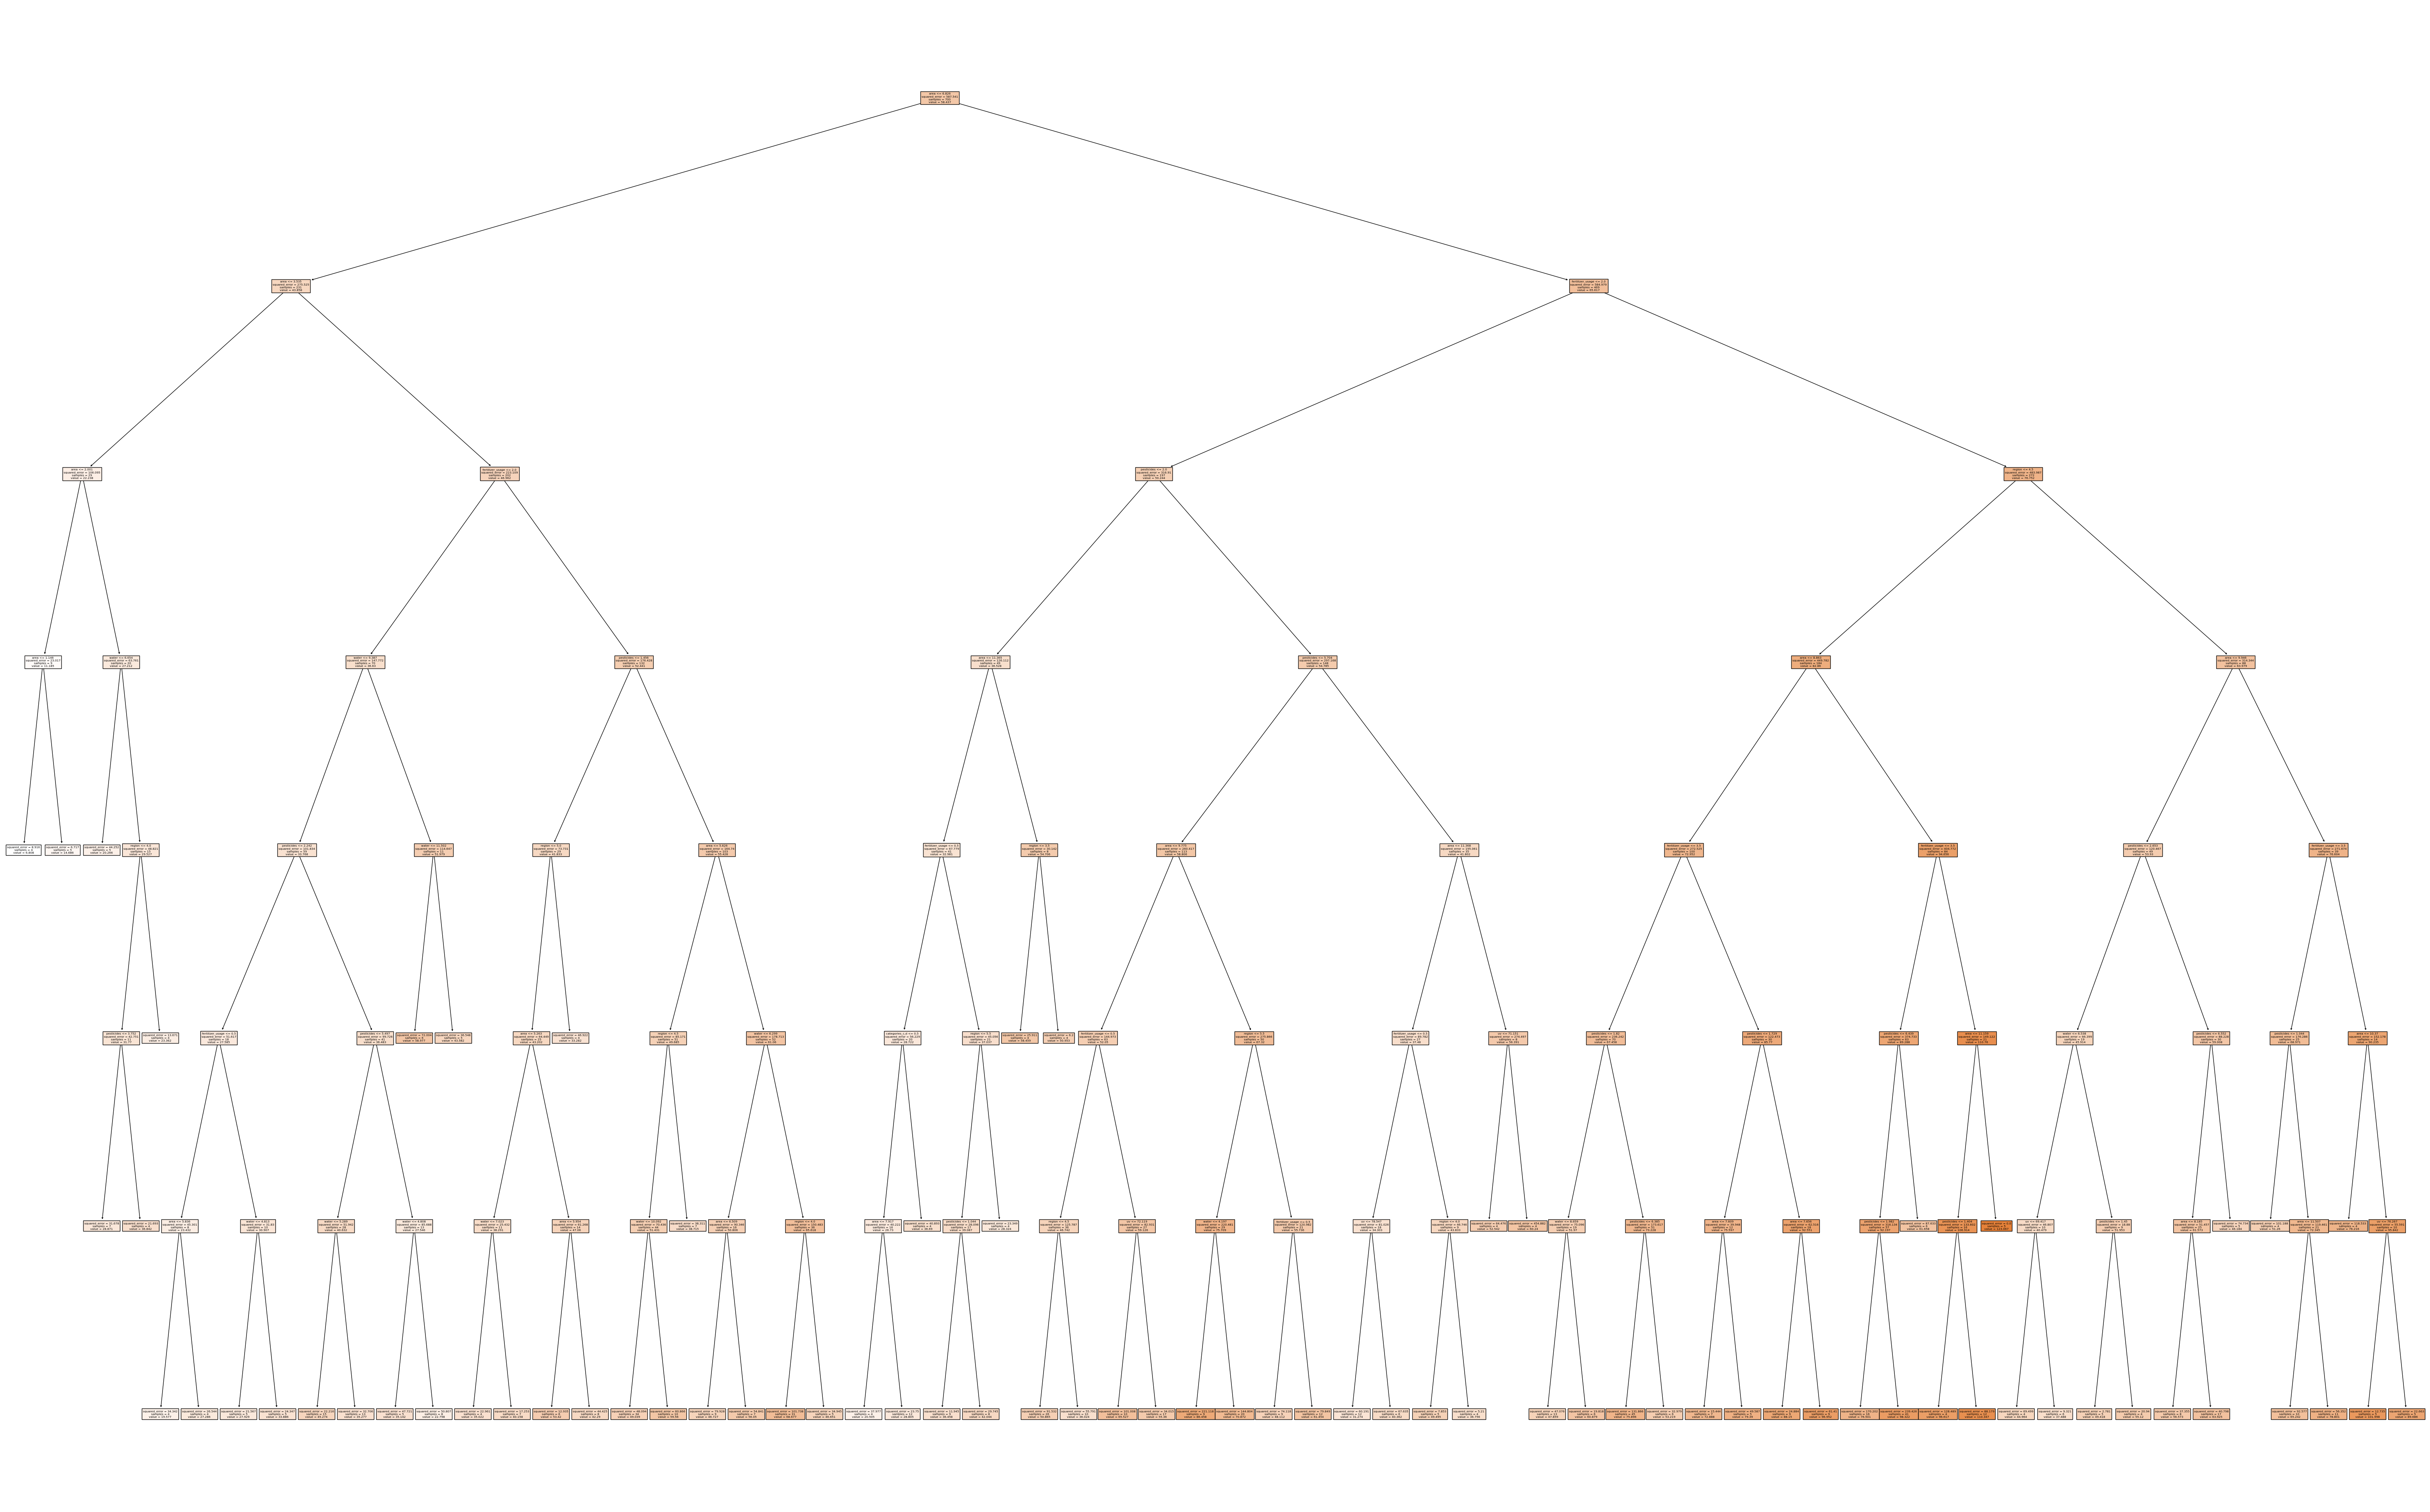

Train RMSE: 8.736239785090369
Validation RMSE: 13.504156317835811


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Apply pre-pruning techniques
pre_pruned_tree = DecisionTreeRegressor(
    max_depth=7, min_samples_split=8, min_samples_leaf=4, random_state=42
)
pre_pruned_tree.fit(X_train, y_train)

# Predict on training and validation sets
y_train_pred_pre_pruned = pre_pruned_tree.predict(X_train)
y_val_pred_pre_pruned = pre_pruned_tree.predict(X_val)

# Calculate and print RMSE for training and validation sets
rmse_train_pre_pruned = root_mean_squared_error(y_train, y_train_pred_pre_pruned)
rmse_val_pre_pruned = root_mean_squared_error(y_val, y_val_pred_pre_pruned)

fig, ax = plt.subplots(figsize=(80, 50))
plot_tree(
    pre_pruned_tree,
    feature_names=X_train.keys(),
    filled=True,
)
plt.show()

print(f"Train RMSE: {rmse_train_pre_pruned}")
print(f"Validation RMSE: {rmse_val_pre_pruned}")

These results indicate a more balanced model compared to the basic, unpruned tree. The training error has increased (as expected due to the model's reduced complexity), and the validation error is somewhat reduced, suggesting reduced overfitting.

### SKlearn Post-pruning

Scikit-learn's post-pruning is implemented through cost complexity pruning. We'll fit a tree with the ccp_alpha parameter, which controls the complexity of the tree and helps to prune it. We will find the optimal ccp_alpha value using cross-validation on the training set and then evaluate the pruned tree on the validation set

In [ ]:
# Grid search for finding the best ccp_alpha for post-pruning
parameters = {"ccp_alpha": [0.001, 0.01, 0.1, 1, 10]}
tree = DecisionTreeRegressor(random_state=42)
clf = GridSearchCV(tree, parameters, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

# Best ccp_alpha value
best_ccp_alpha = clf.best_params_["ccp_alpha"]

# Train a new tree with the best ccp_alpha
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_ccp_alpha)
pruned_tree.fit(X_train, y_train)

# Predict on training and validation sets
y_train_pred_pruned = pruned_tree.predict(X_train)
y_val_pred_pruned = pruned_tree.predict(X_val)

# Calculate and print RMSE for training and validation sets
rmse_train_pruned = root_mean_squared_error(y_train, y_train_pred_pruned)
rmse_val_pruned = root_mean_squared_error(y_val, y_val_pred_pruned)


print(f"Best ccp_alpha: {best_ccp_alpha}")
print(f"RMSE for training set: {rmse_train_pruned}")
print(f"RMSE for validation set: {rmse_val_pruned}")

Best ccp_alpha: 1
RMSE for training set: 7.999587987621436
RMSE for validation set: 14.434149305106823


After applying post-pruning with a ccp_alpha of 1, demonstrates a balanced approach to reducing overfitting by pruning the decision tree to a complexity level that maintains a reasonable fit on the training data while attempting to improve generalization on unseen data. Following this we preform an additonal grid search to optimize the model alpha.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Assuming X_train, X_val, y_train, y_val are already defined

# Train a decision tree to full depth to get ccp_alpha values
full_tree = DecisionTreeRegressor(random_state=42)
full_tree.fit(X_train, y_train)
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Remove the maximum ccp_alpha which prunes the tree to a single node
ccp_alphas = ccp_alphas[:-1]

# Train decision trees for each ccp_alpha and evaluate on the validation set
rmse_val_scores = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    y_val_pred = tree.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_val_pred)  # Corrected this line
    rmse_val_scores.append(rmse_val)

# Find the best ccp_alpha based on validation RMSE
best_alpha = ccp_alphas[np.argmin(rmse_val_scores)]

# Train and evaluate a tree using the best ccp_alpha
best_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
best_tree.fit(X_train, y_train)
y_train_pred = best_tree.predict(X_train)
y_val_pred = best_tree.predict(X_val)
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_val = root_mean_squared_error(y_val, y_val_pred)

print(f"Retuned Best ccp_alpha: {best_alpha}")
print(f"Retuned RMSE on training set: {rmse_train}")
print(f"Retuned RMSE on validation set: {rmse_val}")

Retuned Best ccp_alpha: 0.5415339382936287
Retuned RMSE on training set: 6.366274352033018
Retuned RMSE on validation set: 13.814000019830168


In this assignment on optimizing a regression tree to avoid overfitting, we tried out three different methods: pre-pruning and post-pruning manual, SKlearn's post-prunin. 
- **Basic, Unpruned Model:**
  - Perfectly fit the training data (RMSE = 0.0), but did poorly on the validation set (RMSE = 14.766).
  - Clearly overfitted since it memorized the training data too well.

- **Manual Pre-pruning**:

  - Set maximum depth and minimum samples per leaf to limit tree growth.
  - Resulted in a simpler model with minimal impact on validation RMSE, highlighting the balance challenge. 
  - Resulting Best RMSE: 15.164 with threshold: 15

- **Manual Post-pruning**:

  - Adjusted the fully grown tree using a threshold for RMSE improvement to prune unnecessary branches.
  - Led to better generalizability, lowering validation RMSE to 15.164 and raising training RMSE to 10.594, indicating reduced overfitting.

- **Pre-pruning Techniques:**
  - Made the model simpler by setting limits on the tree's growth and provided the best scoring.
  - Training RMSE increased to 8.74, and validation RMSE to 13.50, showing less overfitting but at the cost of making the model too simple.

- **SKlearn Post-pruning:**
  - Used SKlearn's tools to find the best complexity parameter, balancing the model better.
  - Ended up with a training RMSE of 7.99 and a validation RMSE of 14.43, showing improved balance between fitting the training data and generalizing to new data.

- **Semi-Manual Post-pruning:**
  - Selected the best complexity parameter by manually checking different values.
  - Achieved the best balance with a training RMSE of 6.37 and a validation RMSE of 13.81, proving it's a viable and effective method to reduce overfitting while maintaining good model performance.

Overall, the pre-pruning approach provided the best results, demonstrating it's a practical option for fine-tuning a model's complexity in order to avoid issues with overfitting before finishing the tree reducing the complexity of the model and improving generalizability.

## Task 3 Comparison with Random Forest and SVR (25 Marks):
Optimize parameters for Decision Trees (DTs), Random Forest, and Support Vector Regression (SVR).
Compare results using sutable metrics.
Discuss the strengths and weaknesses of each method.



In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

# For this section we choose to optimize the parameters using a grid search over the hyperparameters

# Decision Tree optimization to be repeated for every model architecture
dt = DecisionTreeRegressor()
dt_params = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "min_impurity_decrease": [0.1, 0.2, 0.5],
}
dt_grid = GridSearchCV(dt, dt_params, cv=5)
dt_grid.fit(X_train, y_train)

# Random Forest optimization
rf = RandomForestRegressor()
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [5, 10, 20, None],
}
rf_grid = GridSearchCV(rf, rf_params, cv=5)  # Create the grid of parameters
rf_grid.fit(X_train, y_train)  # Fit the best model to the data

# SVR optimization
svr = SVR()
params = [
    {"kernel": ["linear"], "C": [1, 10, 100, 100]},
    {"kernel": ["poly"], "C": [1, 10], "degree": [2, 3]},
    {"kernel": ["rbf"], "C": [1, 10, 100, 100], "gamma": [1, 0.1, 0.01, 0.001]},
]

svr_grid = GridSearchCV(svr, params, refit=True, return_train_score=True, cv=5)

svr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1, 10, 100, 100], 'kernel': ['linear']},
                         {'C': [1, 10], 'degree': [2, 3], 'kernel': ['poly']},
                         {'C': [1, 10, 100, 100],
                          'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}],
             return_train_score=True)

In [ ]:
# Get predictions on the training set
dt_train_preds = dt_grid.predict(X_train)
rf_train_preds = rf_grid.predict(X_train)
svr_train_preds = svr_grid.predict(X_train)

# Calculate error metrics from the predictions for training
dt_train_rmse = root_mean_squared_error(y_train, dt_train_preds)
rf_train_rmse = root_mean_squared_error(y_train, rf_train_preds)
svr_train_rmse = root_mean_squared_error(y_train, svr_train_preds)

# Report Model Preformance
print("Decision Tree Train RMSE:", dt_train_rmse)
print("Random Forest Train RMSE:", rf_train_rmse)
print("SVR Train RMSE:", svr_train_rmse)

# Get Validation Predictions
dt_val_preds = dt_grid.predict(X_val)
rf_val_preds = rf_grid.predict(X_val)
svr_val_preds = svr_grid.predict(X_val)

# Get error on validation set
dt_val_mse = root_mean_squared_error(y_val, dt_val_preds)
rf_val_mse = root_mean_squared_error(y_val, rf_val_preds)
svr_val_mse = root_mean_squared_error(y_val, svr_val_preds)

# Return Validation Accuracy
print("Decision Tree Validation RMSE:", dt_val_mse)
print("Random Forest Validation RMSE:", rf_val_mse)
print("SVR Validation RMSE:", svr_val_mse)

Decision Tree Train RMSE: 6.730870330543082
Random Forest Train RMSE: 4.417529508721712
SVR Train RMSE: 6.967082755660797
Decision Tree Validation RMSE: 13.496245769064158
Random Forest Validation RMSE: 13.199842903670463
SVR Validation RMSE: 11.697974363390996


Decision trees offer interpretability but are prone to overfitting. Random Forests reduce overfitting and improve generalization at the cost of increased complexity. SVR provides robustness to overfitting and flexibility in handling non-linear relationships but requires careful parameter tuning and can be computationally expensive. The choice of method depends on the specific characteristics of the dataset, the trade-off between interpretability and performance, and computational considerations.

## Task 4 Classification Task (10 Marks):

Add a threshold to the label column for a classification task.
Assign classes: 20% lowest yield per hectare as "low" and 80% as "high."
Apply SVM, DTs, and optimize parameters then compare them with suitable classification metrics.



In [ ]:
# Defining a copy of data for classification
class_data = y_train

# Defining cutoffs for high low, allowing for changes with minimal changes
low = np.quantile(class_data, 0.2)
high = np.quantile(class_data, 0.2)
classes = pd.DataFrame(class_data)


# Defining classifying function based on true assigned thresholding
def categorize(x):
    if x < low:  # Sorting assignment to the low group
        return 0
    elif (
        x >= low and x <= high
    ):  # Cutting out middle groups should thresholds not be equal
        return np.nan
    else:  # Assigning the remaining data to the high class
        return 1


# Applying the classifying function to the data
classes["labels"] = classes["yield"].apply(categorize)

# Labelling the nan rows to allow for removal
nan_rows_c_t = classes.isna().any(axis=1)

# Repeating the process for the validation set using the seperation from the train set to avoid cheating
class_val = y_val
class_val = pd.DataFrame(class_val)
class_val["labels"] = class_val["yield"].apply(categorize)
nan_rows_c_v = class_val.isna().any(axis=1)

In [ ]:
# Removing nan values from train and validation data (uneeded for these cutoffs but useful if low != high)
train_data = X_train[~nan_rows_c_t]
train_classes = classes[~nan_rows_c_t]
val_data = X_val[~nan_rows_c_v]
val_classes = class_val[~nan_rows_c_v]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn

warnings.filterwarnings("ignore")

# Decision Tree optimization as in part 3
dt = DecisionTreeClassifier()
dt_params = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "min_impurity_decrease": [0.1, 0.2, 0.5],
}
dt_grid = GridSearchCV(dt, dt_params, cv=5)
dt_grid.fit(train_data, train_classes["labels"])

# SVM optimization as in part 3
svm = sklearn.svm.SVC()
params = [
    {"kernel": ["linear"], "C": [1, 10, 100, 100]},
    {"kernel": ["poly"], "C": [1, 10], "degree": [2, 3]},
    {"kernel": ["rbf"], "C": [1, 10, 100, 100], "gamma": [1, 0.1, 0.01, 0.001]},
]

svm_grid = GridSearchCV(svm, params, refit=True, return_train_score=True, cv=5)

svm_grid.fit(train_data, train_classes["labels"])

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 100], 'kernel': ['linear']},
                         {'C': [1, 10], 'degree': [2, 3], 'kernel': ['poly']},
                         {'C': [1, 10, 100, 100],
                          'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}],
             return_train_score=True)

In [ ]:
# Compare results
dt_train_preds = dt_grid.predict(train_data)
svm_train_preds = svm_grid.predict(train_data)

# Calculate precision score for the data
dt_train_pre = sklearn.metrics.precision_score(train_classes["labels"], dt_train_preds)
svm_train_pre = sklearn.metrics.precision_score(
    train_classes["labels"], svm_train_preds
)
dt_train_rec = sklearn.metrics.precision_score(train_classes["labels"], dt_train_preds)
svm_train_rec = sklearn.metrics.precision_score(
    train_classes["labels"], svm_train_preds
)

# Return Train Accuracy
print("Decision Tree Train Precision:", dt_train_pre)
print("SVM Train Precision:", svm_train_pre)
print("Decision Tree Train Recall:", dt_train_rec)
print("SVM Train Recall:", svm_train_rec)

# Run predictions for the validation data
dt_val_preds = dt_grid.predict(val_data)
svm_val_preds = svm_grid.predict(val_data)

# Calculate precision score for the data
dt_val_pre = sklearn.metrics.precision_score(val_classes["labels"], dt_val_preds)
svr_val_pre = sklearn.metrics.precision_score(val_classes["labels"], svm_val_preds)
dt_val_rec = sklearn.metrics.recall_score(val_classes["labels"], dt_val_preds)
svr_val_rec = sklearn.metrics.recall_score(val_classes["labels"], svm_val_preds)

# Return Validation Accuracy
print("Decision Tree Validation Precision:", dt_val_pre)
print("SVM Validation Precision:", svr_val_pre)
print("Decision Tree Validation Recall:", dt_val_rec)
print("SVM Validation Recall:", svr_val_rec)

Decision Tree Train Precision: 0.8
SVM Train Precision: 0.9616055846422339
Decision Tree Train Recall: 0.8
SVM Train Recall: 0.9616055846422339
Decision Tree Validation Precision: 0.8066666666666666
SVM Validation Precision: 0.9007633587786259
Decision Tree Validation Recall: 1.0
SVM Validation Recall: 0.9752066115702479


We choose precision as our most important metric as we seek to misclassify as few low points as high as possible as our data is imbalanced. Through this comparison we see that the SVM model is of higher strength. This is to be expected as in data that is inherently created through regression and thresholding a decision making framework that seperates the data using a line of best fit is likely to identify a line more similar to the line actually used while a decision tree may have more issues with finding these patterns.

## Task 5 Regression Tree as a Classifier (20-30 Marks):

Take the best regression tree from question 2.
Evaluate it as a classification problem following question 4 criteria.
Perform threshold analysis ( like ROC curve) to find the optimal threshold.
Compare the tree with optimal threshold with DTs from question 4. When comparing the results with Decision Trees (DTs) from question 4, consider the scenario where the underlying data is originally regression-based, but the task at hand requires a binary classification of 'yes' and 'no.' Discuss the implications of using regression labels directly versus thresholding them for classification purposes. Provide detailed insights into why one approach may be preferred over the other

Best Recall: 0.9586776859504132
Best Precision: 0.9206349206349206


Text(0.5, 1.0, 'Precision Recall Curve Best threshold: 36.84225')

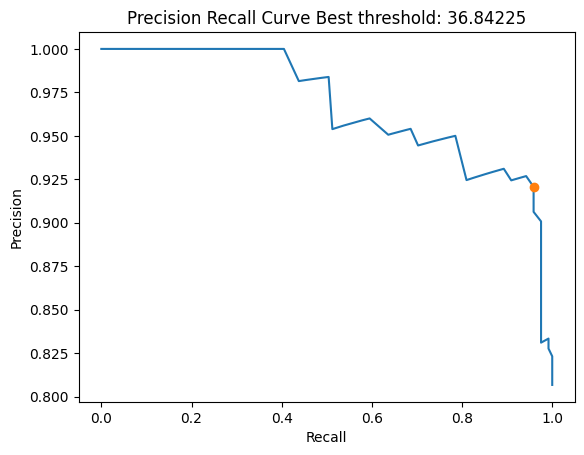

In [ ]:
import matplotlib.pyplot as plt

best_tree = pre_pruned_tree
# Running the regression tree model
predicitons = best_tree.predict(val_data)

# Creating a precision recall curve by varying the thresholds at every value in the dataset
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
    val_classes["labels"], predicitons
)

# Test all point distances to find the optimal threshold to be near the corner of the curve
best_i = 0
best_distance = 100
best_prec = 0
best_rec = 0
for i in range(len(recall)):
    distance = (1 - recall[i]) ** 2 + (1 - precision[i]) ** 2
    if distance <= best_distance:
        best_i = i
        best_distance = distance
        best_prec = precision[i]
        best_rec = recall[i]

print("Best Recall:", best_rec)
print("Best Precision:", best_prec)
# Plot the curve alongside the optimal point
plt.plot(recall, precision)
plt.plot(recall[best_i], precision[best_i], "o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision Recall Curve Best threshold: {thresholds[best_i]}")

When comparing the results with Decision Trees (DTs) from question 4, consider the scenario where the underlying data is originally regression-based, but the task at hand requires a binary classification of 'yes' and 'no.' Discuss the implications of using regression labels directly versus thresholding them for classification purposes. Provide detailed insights into why one approach may be preferred over the other

When compared to the classification tree from part four we can see a much stronger model using regression trees and thresholding. When using regression directly we are able to find an optimum threshold in terms of precision such that a level can be found that is highly likely to mirror the true threshold we applied to the given yields. As such we expect the use of the labels directly to be the better approach as with access to the regression outputs we are able to identify when specific predictions are near the threshold where if we threshold the data as part of a classification tree we lose the information about points that are closer to the border and as such more likely to be misclassified or of little value.